In [32]:
!conda install -c conda-forge leidenalg --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Retrieving notices: ...working... done


In [33]:
#To get detailed description if get CUDA error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [34]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [35]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity

import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

In [36]:
st = time.time()

In [37]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [38]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ['Pancreas CelSeq2', 'Pancreas SS2']


trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [39]:
# url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
# output = 'pancreas.h5ad'
# gdown.download(url, output, quiet=False)

In [40]:
adata_all = sc.read('pancreas.h5ad')

/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/X' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/anndata/_io/h5ad.py:282: OldFormatWarning: '/obs' was written with a very old version of AnnData. Consider rewriting it.
  OldFormatWarning,
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/uns' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/uns/batch_categories' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/uns/cell_type_categories' was wr

In [41]:
adata = adata_all.raw.to_adata()
adata = remove_sparsity(adata)
source_adata = adata[adata.obs['study'].isin(['Pancreas CelSeq2'])]
source_conditions = source_adata.obs[condition_key].unique().tolist()
source_conditions
adata.obs

,batch,study,cell_type,size_factors
index,,,,
0-0-0-0-0,0,Pancreas inDrop,Pancreas Endothelial,13073.0
1-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,17227.0
2-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,7844.0
3-0-0-0-0,0,Pancreas inDrop,Pancreas Acinar,10966.0
4-0-0-0-0,0,Pancreas inDrop,Pancreas Endothelial,8815.0
...,...,...,...,...
2984-1,1,Pancreas SS2,Pancreas Gamma,221018.0
2985-1,1,Pancreas SS2,Pancreas Alpha,161140.0
2986-1,1,Pancreas SS2,Pancreas Delta,144527.0


In [42]:
adata_tasks = ['Pancreas CelSeq', 'Pancreas Fluidigm C1', 'Pancreas SS2','Pancreas inDrop'] #'Pancreas CelSeq2',

In [43]:
source_adata

View of AnnData object with n_obs × n_vars = 2426 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [44]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
 )


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 1000 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [45]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=0,
    learning_approach='ewc',
)

ewc is happening!
 |███████-------------| 36.8%  - val_loss: 794.7252197266 - val_recon_loss: 783.4800109863 - val_kl_loss: 12.2898383141 - val_mmd_loss: 0.00000000000
ADJUSTED LR
 |████████------------| 40.8%  - val_loss: 793.1543273926 - val_recon_loss: 780.8401489258 - val_kl_loss: 12.3141846657 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |████████------------| 43.8%  - val_loss: 791.5486755371 - val_recon_loss: 779.3157958984 - val_kl_loss: 12.2328758240 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |█████████-----------| 45.2%  - val_loss: 791.8739624023 - val_recon_loss: 779.6237182617 - val_kl_loss: 12.2502489090 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Calculating fisher information!
Saving best state of network...
Best State was in Epoch 204


In [46]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

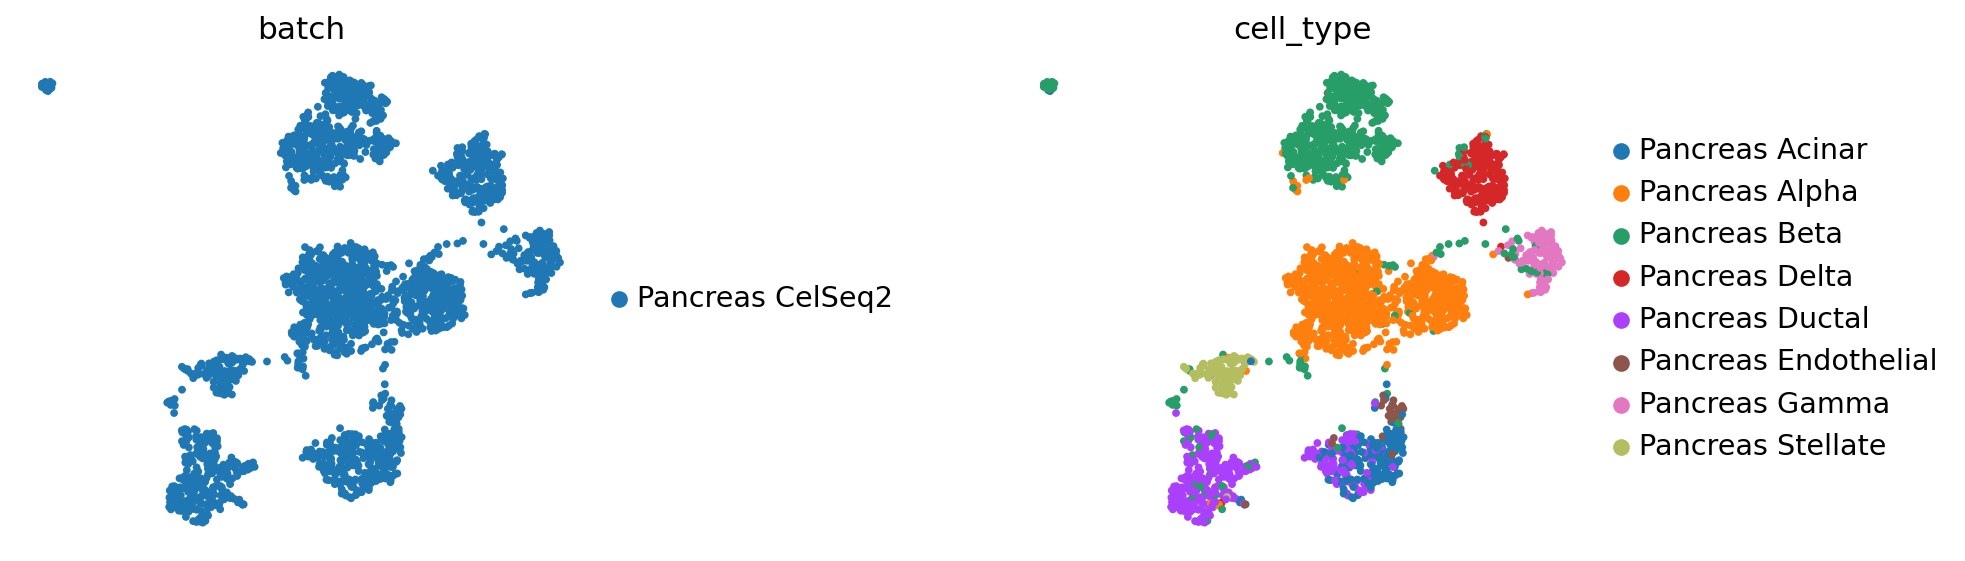

In [47]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [48]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

In [49]:
for ID, task in enumerate(adata_tasks, start=1): #adata_tasks[1:] if you wanna skip the first item
    print(ID)
    task_i = adata[adata.obs[condition_key].isin([task])]
    new_trvae = sca.models.TRVAE.load_query_data(adata=task_i,
                                                 learning_approach = 'ewc',
                                                 model=ref_path)
    new_trvae.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=ID,
    weight_decay=0,
    learning_approach = 'ewc'
    )
    
    ref_path = 'reference_model/'#+ str (ID)
    new_trvae.save(ref_path, overwrite=True)

1

INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 1000 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 2
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 

ewc is happening!
 |████----------------| 21.6%  - val_loss: 530.7153930664 - val_recon_loss: 521.2507324219 - val_kl_loss: 17.6909408569 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |██████--------------| 31.8%  - val_loss: 533.9821777344 - val_recon_loss: 521.2045288086 - val_kl_loss: 16.1742763519 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |██████--------------| 33.2%  - val_loss: 534.6151733398 - val_recon_loss: 521.2780761719 - val_kl_loss: 16.1661472321 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Calculating fisher information!
Saving best state of ne

In [50]:
surg_path = 'surgery_model'
new_trvae.save(surg_path, overwrite=True)

In [51]:
full_latent = sc.AnnData(new_trvae.get_latent(adata.X, adata.obs[condition_key]))
full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata.obs[condition_key].tolist()
full_latent.obsm

AxisArrays with keys: 

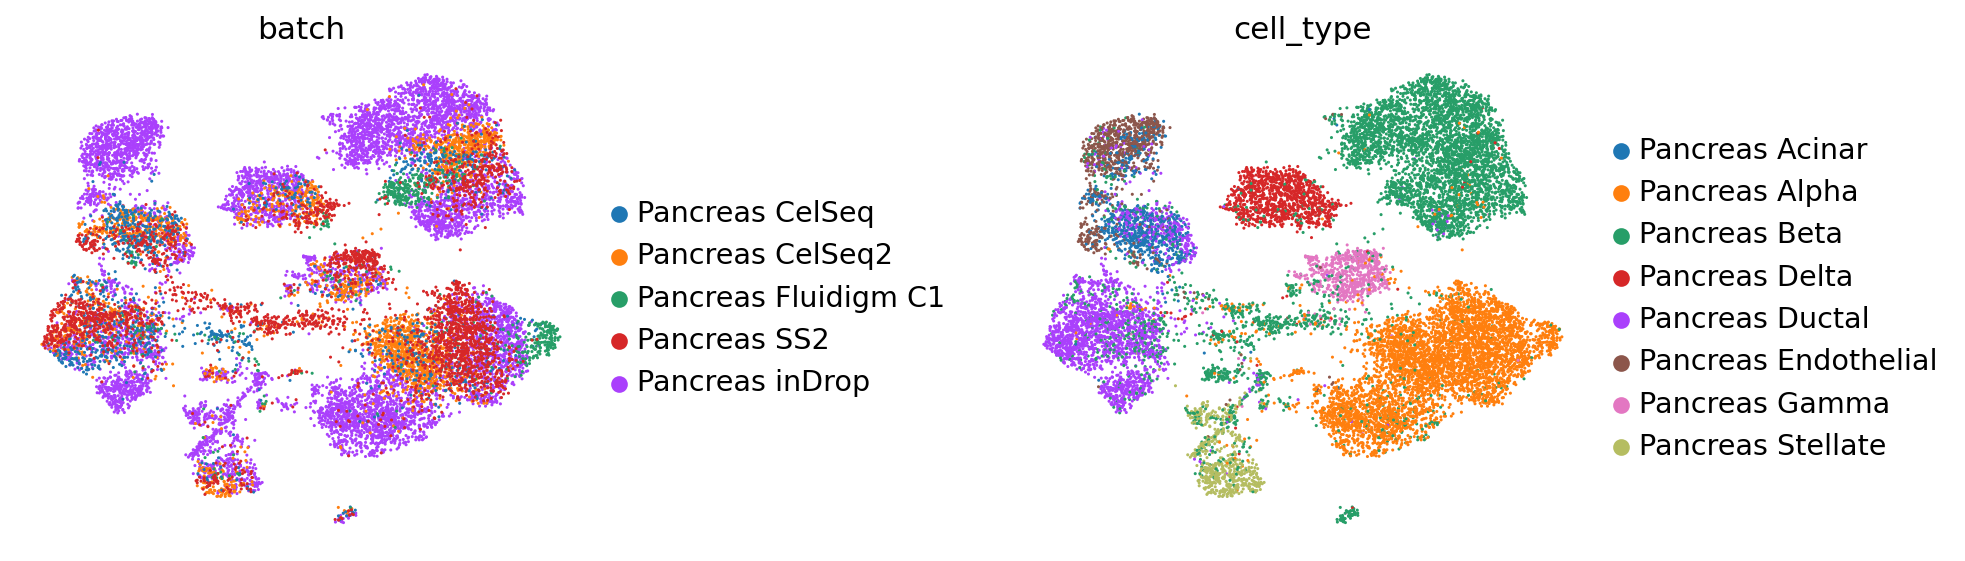

In [52]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [53]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:24:40


In [54]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(full_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_conn_EWC_1=scib.metrics.graph_connectivity(full_latent, 'batch')
Batch_corr_graph_conn_EWC_1

0.907825266669773

In [55]:
sc.tl.umap(adata_latent)
Batch_corr_ASW_EWC_1=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_EWC_1

mean silhouette per group:                       silhouette_score
group                                 
Pancreas Acinar               0.750638
Pancreas Alpha                0.770253
Pancreas Beta                 0.784449
Pancreas Delta                0.843895
Pancreas Ductal               0.784697
Pancreas Endothelial          0.489040
Pancreas Gamma                0.827233
Pancreas Stellate             0.704172


0.7442970386211107

In [56]:
Bio_cons_ASW_EWC_1=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_EWC_1

0.5981042683124542

In [57]:
isolated_labels_EWC_1=scib.metrics.isolated_labels(full_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_EWC_1

isolated labels: no more than 5 batches per label


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Acinar: 0.619934282584885


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Alpha: 0.9578063556169626


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Beta: 0.8367992766726944


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Delta: 0.953831508805331


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Ductal: 0.8217054263565892


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Endothelial: 0.7532621589561092


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Gamma: 0.9271623672230651


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Stellate: 0.8686543110394842


0.8423944609068901

In [58]:
pcr_EWC_1=scib.metrics.pcr_comparison(source_adata, adata, covariate='batch', embed=None, n_comps=50, scale=False, verbose=False)
pcr_EWC_1

0.02870146673652502